# Rising Covid-19 Outbreak and Unemployment in IL

#####  Author: Jeremy Carnahan

***

As we enter into what many consider the "3rd wave" of COVID-19 outbreaks, we have heard about the consequences on the Illinois economy with a drastic rise in layoffs.  **This Jupyter Notebook will walk you through using Python to combin, analyze, and visualize three datasets to illustrate county-by-county unemployment rates as COVID-19 comfirmed rates increase.**  




Let's begin by importing our necessary Python modules below.  Note that I've pulled all of these packages using Anaconda with the 'conda-forge' channel.

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display, clear_output

### Bureau of Labor Statistics Unemployment Data
Our first dataset is a monthly .csv from the United States Bureau of Labor Statistics (BLS) which is made open source to the public as it originates from the United States government, making its licensed use within the public domain.  The data is attached to this project and called:  la.data.20.Illinois.txt.  We'll primarily be filtering down the data to just IL unemployment rates, for all counties, in the year 2020.  County Federal Information Processing Standard (FIPS) codes will be parsed from the statistics to pair up with geographical country boundaries data described later.  The 23MB file of BLS unemployment rate data for Illinois can be found on the BLS [website](https://download.bls.gov/pub/time.series/la/la.data.20.Illinois) in the format of a text (.txt) file. Its data dictionary is found [here](https://download.bls.gov/pub/time.series/la/la.txt).

We'll read in the data (tab delimited text file), and begin parsing and data-typing date fields for easier operations in our time series analysis.  

```python
bls_raw_il = pd.read_csv('./la.data.20.Illinois_10_20.txt', sep='\t')
bls_raw_il
```

In [2]:
bls_raw_il = pd.read_csv('./la.data.20.Illinois_10_20.txt', sep='\t')
bls_raw_il

,series_id,year,period,value,footnote_codes
0,LASBS170000000000003,1994,M01,5.8,NaN
1,LASBS170000000000003,1994,M02,5.8,NaN
2,LASBS170000000000003,1994,M03,5.8,NaN
3,LASBS170000000000003,1994,M04,5.7,NaN
4,LASBS170000000000003,1994,M05,5.5,NaN
...,...,...,...,...,...
437089,LAUST170000000000009,2020,M06,9981183.0,NaN
437090,LAUST170000000000009,2020,M07,9980184.0,NaN
437091,LAUST170000000000009,2020,M08,9979489.0,NaN
437092,LAUST170000000000009,2020,M09,9978718.0,NaN


Here is where researching BLS' data coding [metadata](https://www.bls.gov/help/hlpforma.htm) was necessary to understand that the "series_id" will include a prefix 'LAUCN' to indicate unemployment for county level, '17XXX' for the FIPS code of the county, and ending of '003' to indicate the data is unemployment rate instead of number unemployed.  

```python
bls_rate_il = bls_raw_il[bls_raw_il['series_id'].str.contains('0000000003')]
bls_rate_year = pd.to_datetime(bls_rate_il.year, format='%Y')

bls_rate_2020_il = bls_rate_il[bls_rate_il['year'] == 2020] #subset to only the current 2020 year
bls_rate_2020_il_cn = bls_rate_2020_il[bls_rate_2020_il['series_id'].str.contains('LAUCN')] #subet to IL county data

bls_rate_2020_il_cn

```

In [3]:
bls_rate_il = bls_raw_il[bls_raw_il['series_id'].str.contains('0000000003')]
bls_rate_year = pd.to_datetime(bls_rate_il.year, format='%Y')


In [4]:
bls_rate_2020_il = bls_rate_il[bls_rate_il['year'] == 2020] #subset to only the current 2020 year
bls_rate_2020_il_cn = bls_rate_2020_il[bls_rate_2020_il['series_id'].str.contains('LAUCN')] #subet to only IL county data

In [5]:
bls_rate_2020_il_cn

,series_id,year,period,value,footnote_codes
18786,LAUCN170010000000003,2020,M01,3.3,NaN
18787,LAUCN170010000000003,2020,M02,2.8,NaN
18788,LAUCN170010000000003,2020,M03,2.5,NaN
18789,LAUCN170010000000003,2020,M04,12.0,NaN
18790,LAUCN170010000000003,2020,M05,10.5,NaN
...,...,...,...,...,...
180391,LAUCN172030000000003,2020,M06,9.3,NaN
180392,LAUCN172030000000003,2020,M07,7.3,NaN
180393,LAUCN172030000000003,2020,M08,6.5,NaN
180394,LAUCN172030000000003,2020,M09,5.6,NaN


Next we need to convert the period data from a "Mxx" to an actual month that we'll use in our later time series analysis.  We'll do this by setting conditions with pandas .select() method.  I found guidance on this approach by Charlie Custer on dataquest.io here: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/

```python
conditions = [
    (bls_rate_2020_il_cn['period'] == 'M01'),
    (bls_rate_2020_il_cn['period'] == 'M02'),
    (bls_rate_2020_il_cn['period'] == 'M03'),
    (bls_rate_2020_il_cn['period'] == 'M04'),
    (bls_rate_2020_il_cn['period'] == 'M05'),
    (bls_rate_2020_il_cn['period'] == 'M06'),
    (bls_rate_2020_il_cn['period'] == 'M07'),
    (bls_rate_2020_il_cn['period'] == 'M08'),
    (bls_rate_2020_il_cn['period'] == 'M09'),
    (bls_rate_2020_il_cn['period'] == 'M10'),
    (bls_rate_2020_il_cn['period'] == 'M11'),
    (bls_rate_2020_il_cn['period'] == 'M12')
]

mo_values = ['01-2020', '02-2020', '03-2020', '04-2020', '05-2020', '06-2020', '07-2020', '08-2020', '09-2020',
            '10-2020', '11-2020', '12-2020']

bls_rate_2020_il_cn['dateString'] = np.select(conditions, mo_values)
bls_rate_2020_il_cn = bls_rate_2020_il_cn.reset_index(drop=True) 

```

In [6]:
conditions = [
    (bls_rate_2020_il_cn['period'] == 'M01'),
    (bls_rate_2020_il_cn['period'] == 'M02'),
    (bls_rate_2020_il_cn['period'] == 'M03'),
    (bls_rate_2020_il_cn['period'] == 'M04'),
    (bls_rate_2020_il_cn['period'] == 'M05'),
    (bls_rate_2020_il_cn['period'] == 'M06'),
    (bls_rate_2020_il_cn['period'] == 'M07'),
    (bls_rate_2020_il_cn['period'] == 'M08'),
    (bls_rate_2020_il_cn['period'] == 'M09'),
    (bls_rate_2020_il_cn['period'] == 'M10'),
    (bls_rate_2020_il_cn['period'] == 'M11'),
    (bls_rate_2020_il_cn['period'] == 'M12')
]

mo_values = ['01-2020', '02-2020', '03-2020', '04-2020', '05-2020', '06-2020', '07-2020', '08-2020', '09-2020',
            '10-2020', '11-2020', '12-2020']

In [7]:
bls_rate_2020_il_cn['dateString'] = np.select(conditions, mo_values)
bls_rate_2020_il_cn = bls_rate_2020_il_cn.reset_index(drop=True) #Found way to reindex from StackOverflow by Shubham Sharma
# here: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe 

C:\Users\UIUC\anaconda3\envs\DataViz\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


I need to also extract the Illinois county's federal ID code (FIPS) in order to later join with geographical boarder data.  We'll do that in Pandas by applying a slicing method and adding a new column called "fips". 

```python

bls_rate_2020_il_cn['fips'] = bls_rate_2020_il_cn.series_id.str[7:10]  

bls_rate_2020_il_cn

```

In [8]:
bls_rate_2020_il_cn['fips'] = bls_rate_2020_il_cn.series_id.str[7:10]  

In [9]:
bls_rate_2020_il_cn

,series_id,year,period,value,footnote_codes,dateString,fips
0,LAUCN170010000000003,2020,M01,3.3,NaN,01-2020,001
1,LAUCN170010000000003,2020,M02,2.8,NaN,02-2020,001
2,LAUCN170010000000003,2020,M03,2.5,NaN,03-2020,001
3,LAUCN170010000000003,2020,M04,12.0,NaN,04-2020,001
4,LAUCN170010000000003,2020,M05,10.5,NaN,05-2020,001
...,...,...,...,...,...,...,...
1015,LAUCN172030000000003,2020,M06,9.3,NaN,06-2020,203
1016,LAUCN172030000000003,2020,M07,7.3,NaN,07-2020,203
1017,LAUCN172030000000003,2020,M08,6.5,NaN,08-2020,203
1018,LAUCN172030000000003,2020,M09,5.6,NaN,09-2020,203



### State of Illinois COVID-19 Confirmed Cases
The second dataset is a daily data aggregation of all IL COVID-19 statistics in the state of Illinois and hosted on [Observable.com](https://observablehq.com/@chicagoreporter/coronavirus-illinois-historical-counts) by "The Chicago Reporter".  The data is made available to the public under a MIT License.  Much of the real-time statistics come from an IL Department of Health API; however, The Chicago Reporter has parsed through and reformatted into an easily consumable .csv file for analysis.  The data is attached to this project, and we'll begin by loading it into the notebook.

```python
covid_raw_il = pd.read_csv('./il-statewide-covid-counts-through-2020-12-06.csv', sep=',', parse_dates=['dateString'],
                          index_col=['dateString'])

covid_raw_il
```

In [10]:
covid_raw_il = pd.read_csv('./il-statewide-covid-counts-through-2020-12-06.csv', sep=',', parse_dates=['dateString'],
                          index_col=['dateString'])

# To datetime found on Pandas Docs:  https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-csv-mixed-timezones
covid_raw_il

,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,confirmed_cases_minus_deaths,deaths,deaths_change,deaths_change_pct,total_tested,total_tested_change,total_tested_change_pct,date
dateString,,,,,,,,,,,
2020-01-24,1,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,2020-01-24T00:00:00.000Z
2020-01-30,2,1.0,100.00,2,0,0.0,0.00,NaN,NaN,0.00,2020-01-30T00:00:00.000Z
2020-02-29,3,1.0,50.00,3,0,0.0,0.00,NaN,NaN,0.00,2020-02-29T00:00:00.000Z
2020-03-02,4,1.0,33.33,4,0,0.0,0.00,NaN,NaN,0.00,2020-03-02T00:00:00.000Z
2020-03-05,5,1.0,25.00,5,0,0.0,0.00,NaN,NaN,0.00,2020-03-05T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-02,748603,9757.0,1.32,735965,12638,235.0,1.89,10699586.0,85507.0,0.81,2020-12-02T00:00:00.000Z
2020-12-03,759562,10959.0,1.46,746736,12826,188.0,1.49,10806364.0,106778.0,1.00,2020-12-03T00:00:00.000Z
2020-12-04,770088,10526.0,1.39,757117,12971,145.0,1.13,10918998.0,112634.0,1.04,2020-12-04T00:00:00.000Z


In [11]:
# Found an excellent tutorial on using datetime from normal Pandas object here:
# https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/


Since the BLS data is only offered on a monthly, instead of daily cadence like the COVID data, we have to group up the COVID data into monthly metrics, identifying the maximum infection rate for that month.  We could have also just extracted the last day of the month, as the rates are cumulative; however, the logic is easier to just identify a monthly maximum using Pandas Grouper method with "M" monthly parameter.

```python

covid_raw_il.reset_index(inplace=True)
covid_il_grouped = covid_raw_il.groupby(pd.Grouper(key='dateString', freq='M')).max()
covid_il_grouped.reset_index(inplace=True)
# We'll convert the 'dateString' Pandas series to a dateTime data type.
covid_il_grouped['dateString'] = covid_il_grouped['dateString'].dt.strftime('%m-%Y')
covid_il_grouped
```

In [12]:
# We need to reindex back to a range index in order to use pandas .grouper() method later to groupby and aggregate by max.
covid_raw_il.reset_index(inplace=True)

# # Let's drop the month's day since we'll be joining with unemployment data above without day.
# covid_raw_il['dateString'] = covid_raw_il['dateString'].dt.strftime('%m-%Y') #this didn't work!  I found I need to use .dt
# on my last step, otherwise I will always lose dateTime .dtype.
# https://stackoverflow.com/questions/52869614/pandas-convert-datetime-format-mm-dd-yyyy-to-dd-mm-yyyy

In [13]:
# Used Grouper() method from Pandas to group by month and average values using Pandas docs for guidance here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html?highlight=grouper
covid_il_grouped = covid_raw_il.groupby(pd.Grouper(key='dateString', freq='M')).max()

In [14]:
covid_il_grouped.reset_index(inplace=True)

In [15]:
covid_il_grouped['dateString'] = covid_il_grouped['dateString'].dt.strftime('%m-%Y')

In [16]:
covid_il_grouped

,dateString,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,confirmed_cases_minus_deaths,deaths,deaths_change,deaths_change_pct,total_tested,total_tested_change,total_tested_change_pct,date
0,01-2020,2,1.0,100.00,2,0,0.0,0.00,NaN,NaN,0.00,2020-01-30T00:00:00.000Z
1,02-2020,3,1.0,50.00,3,0,0.0,0.00,NaN,NaN,0.00,2020-02-29T00:00:00.000Z
2,03-2020,5994,1105.0,100.00,5895,99,27.0,200.00,35225.0,4911.0,59.46,2020-03-31T00:00:00.000Z
3,04-2020,52918,2724.0,16.45,50563,2355,142.0,42.42,269867.0,16124.0,14.65,2020-04-30T00:00:00.000Z
4,05-2020,120260,4014.0,5.93,114871,5389,191.0,6.61,898259.0,29307.0,6.61,2020-05-31T00:00:00.000Z
5,06-2020,143185,1614.0,1.33,136264,6921,116.0,2.07,1602965.0,31686.0,2.62,2020-06-30T00:00:00.000Z
6,07-2020,178837,1941.0,1.10,171342,7495,37.0,0.53,2699568.0,49782.0,2.13,2020-07-31T00:00:00.000Z
7,08-2020,235023,2356.0,1.15,226998,8025,36.0,0.45,4064161.0,56766.0,1.64,2020-08-31T00:00:00.000Z
8,09-2020,293274,5368.0,2.24,284603,8671,39.0,0.49,5624822.0,149273.0,3.59,2020-09-30T00:00:00.000Z
9,10-2020,410300,7899.0,1.96,400543,9757,67.0,0.72,7729845.0,95111.0,1.34,2020-10-31T00:00:00.000Z



Now we have to join the data between the BLS monthly unemployment rates for IL counties and the IL COVID data aggregated at a monthly level.


In [17]:
lau_covid_il = pd.merge(bls_rate_2020_il_cn, covid_il_grouped, how='left', on=['dateString', 'dateString'])

In [18]:
# Here we need to convert the fips column to an int so we can merge with the IL county geopandas boundaries below.
lau_covid_il['fips'] = pd.to_numeric(lau_covid_il['fips'])

### IL Geographical Boundary Data
Finally, we introduce the state and county boundary data from ESRI who makes this data freely available and allows data retrievals from their host API.  The dataset is a .geojson file of IL state and county boundaries that we will join with our BLS and IL COVID-19 data to help visualize counties with rising unemployment rates as we visualize the rising rates of confirmed COVID-19 cases.  The data is hosted by ESRI, and is made available to the public in a Creative Commons license.  The data can be accessed on ESRI [here](https://opendata.arcgis.com/datasets/72da6887c3fc4070b62f534eac5ea079_0.geojson).  

```python

il_bound = gpd.read_file("https://opendata.arcgis.com/datasets/72da6887c3fc4070b62f534eac5ea079_0.geojson")
il_bound

```

In [19]:
# ESRI Open data with Creative Commons license found here: 
# https://www.arcgis.com/home/item.html?id=72da6887c3fc4070b62f534eac5ea079
il_bound = gpd.read_file("https://opendata.arcgis.com/datasets/72da6887c3fc4070b62f534eac5ea079_0.geojson")

In [20]:
il_bound

,FID,AREA_,PERIMETER,NC4_,NC4_ID,FIPS_CO,STATE_CODE,TOTALPOP,NAME_LC,DISTRICT,COUNTY_NAM,STR_STATEC,SHAPE_area,SHAPE_len,GlobalID,geometry
0,1,1.314209e+10,504248.19090,2,3,97,49,519515,lake,1,LAKE,049,1.314209e+10,504248.166488,55f98094-bcc0-4607-a199-467bc5df2139,"POLYGON ((-87.80265 42.49259, -87.80256 42.491..."
1,2,1.704184e+10,522912.63363,3,5,111,56,183241,mchenry,1,MCHENRY,056,1.704263e+10,522779.162317,0ef63edc-8fe9-4d46-a5f3-e1b75495f9d1,"POLYGON ((-88.19946 42.49407, -88.19944 42.492..."
2,3,1.724584e+10,579951.49059,4,1,85,43,21821,jodaviess,2,JO DAVIESS,043,1.724584e+10,579951.512994,d568bb64-2c05-466a-817a-8504e63d6540,"POLYGON ((-90.63082 42.50789, -90.61836 42.507..."
3,4,1.574499e+10,506026.51459,5,2,177,89,48052,stephenson,2,STEPHENSON,089,1.574499e+10,506026.547630,2b46c7bf-691b-4e3f-9395-6a27984f5885,"POLYGON ((-89.74155 42.50539, -89.74155 42.505..."
4,5,1.447768e+10,501614.78373,6,4,201,101,252913,winnebago,2,WINNEBAGO,101,1.447768e+10,501614.722490,74d3257f-8e23-4bbf-91b1-b5cf2b4650c4,"POLYGON ((-89.38438 42.50033, -89.38293 42.500..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,98,9.723745e+09,422725.03361,99,98,87,44,11347,johnson,9,JOHNSON,044,9.723745e+09,422725.029759,05214a4a-18af-4938-9418-c4e1f8f6c5e0,"POLYGON ((-88.76045 37.60023, -88.75383 37.600..."
98,99,1.176391e+10,489546.21914,100,99,181,91,17619,union,9,UNION,091,1.176391e+10,489546.255506,a0451377-b2a4-43a1-a85e-92dae9179937,"POLYGON ((-89.09913 37.59795, -89.09870 37.597..."
99,100,6.758354e+09,379787.08595,101,100,127,64,14752,massac,9,MASSAC,064,6.758354e+09,379787.129540,06b40696-a54e-465c-9896-131d0c6b9ab1,"POLYGON ((-88.71063 37.33699, -88.70445 37.332..."
100,101,5.670785e+09,459129.16659,102,102,153,77,7523,pulaski,9,PULASKI,077,5.670784e+09,459129.227046,0be0e256-307f-4057-922a-ece257de8a7d,"POLYGON ((-89.21666 37.33514, -89.20959 37.334..."



Let's have a quick look at the IL boundaries plot with matplotlib, to make sure everything looks as we expect.  Later we'll introduce the COVID and BLS unemployment data with this geodataframe to create a choropleth heatmap of unemployment rates by month.  But next, let's join the IL boundaries data with our already merged BLS and COVID data to create our final, main dataset.


```python
fig, ax = plt.subplots(figsize=(10,10))
il_bound.plot(ax=ax)
plt.show()

```

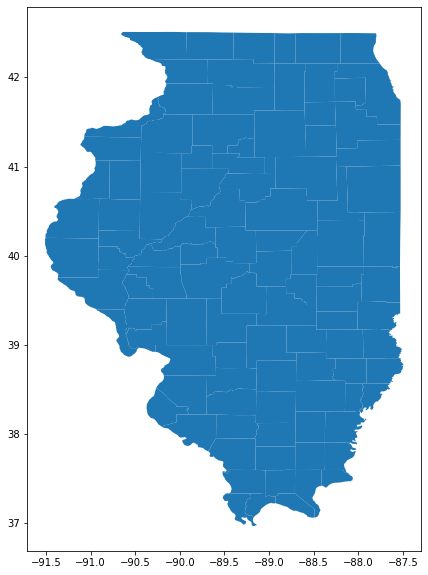

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
il_bound.plot(ax=ax)
plt.show()

Now we join all three cleaned datasets into one workable dataset for our dashboard visualization.

```python
il_covid_map = pd.merge(lau_covid_il, il_bound, how='left', left_on='fips', right_on='FIPS_CO')

il_covid_map
```

In [22]:
il_covid_map = pd.merge(lau_covid_il, il_bound, how='left', left_on='fips', right_on='FIPS_CO')

In [23]:
il_covid_map

,series_id,year,period,value,footnote_codes,dateString,fips,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,...,STATE_CODE,TOTALPOP,NAME_LC,DISTRICT,COUNTY_NAM,STR_STATEC,SHAPE_area,SHAPE_len,GlobalID,geometry
0,LAUCN170010000000003,2020,M01,3.3,NaN,01-2020,1,2,1.0,100.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
1,LAUCN170010000000003,2020,M02,2.8,NaN,02-2020,1,3,1.0,50.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
2,LAUCN170010000000003,2020,M03,2.5,NaN,03-2020,1,5994,1105.0,100.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
3,LAUCN170010000000003,2020,M04,12.0,NaN,04-2020,1,52918,2724.0,16.45,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
4,LAUCN170010000000003,2020,M05,10.5,NaN,05-2020,1,120260,4014.0,5.93,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,LAUCN172030000000003,2020,M06,9.3,NaN,06-2020,203,143185,1614.0,1.33,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1016,LAUCN172030000000003,2020,M07,7.3,NaN,07-2020,203,178837,1941.0,1.10,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1017,LAUCN172030000000003,2020,M08,6.5,NaN,08-2020,203,235023,2356.0,1.15,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1018,LAUCN172030000000003,2020,M09,5.6,NaN,09-2020,203,293274,5368.0,2.24,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."


In [24]:
# I was having issues with plotting my new merged dataframe, and found on this StackOverflow that when I performed the merge
# above between a pandas dataframe and a geopandas dataframe, it takes the type of a regular Pandas dataframe.  
# Solution provided by Dharman here: https://stackoverflow.com/questions/63974040/line2d-object-has-no-property-column
il_covid_map = GeoDataFrame(il_covid_map)

Now with the data in its final form, let extract just one month of data and plot it into a matplotlib based on the 'value' column which will use all of the unemployment rates per county for the month of September 2020 to create a heatmap/choropleth.  It will also create a legend showing the range of unemployment rates.

```python
sept = il_covid_map[il_covid_map['dateString']=='09-2020']
columnfig = sept.plot(column='value',cmap='cool',figsize=(10,10),
                              legend = True, legend_kwds={'label': "Unemployment Rate by County",'orientation': "horizontal"})
# remove axis ticks
plt.axis('off')
plt.title("Sept. IL County Unemployment Heatmap")
plt.show()
```

In [25]:
sept = il_covid_map[il_covid_map['dateString']=='09-2020']

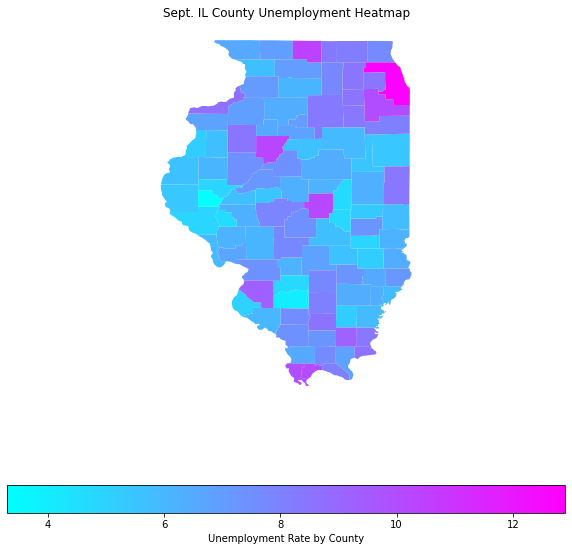

In [26]:
# Generate the choropleth map using gdf plot function on the Confirmed 
# I liked the styling that Kishan Nagaraj used for his Covid-19 world map, but his code did not seem well formed when compared
# to what we learned in this class.  I instead reused his color choices, but used Dr. Naiman's code approach below.
columnfig = sept.plot(column='value',cmap='cool',figsize=(10,10),
                              legend = True, legend_kwds={'label': "Unemployment Rate by County",'orientation': "horizontal"})
# remove axis ticks
plt.axis('off')
plt.title("Sept. IL County Unemployment Heatmap")
plt.show()

Now here is where we build out our final dashboard using the data that we've looked at above.  We'll create an option for the end-user to select from a series of buttons with the associated months.  Since we only have BLS unemployment data up to October (even though it is December, BLS has yet to extract unemployment numbers for November), we'll need to include some Try/Except logic to notify the user that not all data is available when they select a month button without data.

```python
# Resetting our COVID dataset to index by time for easier time series analysis.
covid_raw_il['dateString'] = pd.to_datetime(covid_raw_il['dateString'], format='%m-%Y')
covid_raw_il.set_index('dateString', inplace=True)

month_toggle = ipywidgets.ToggleButtons(
    options=['01-2020', '02-2020', '03-2020', '04-2020','05-2020','06-2020','07-2020','08-2020','09-2020','10-2020','11-2020',
            '12-2020'],
    description='Period:',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)

month_name = {
    '01-2020':'Janurary',
    '02-2020':'February',
    '03-2020':'March',
    '04-2020':'April',
    '05-2020':'May',
    '06-2020':'June',
    '07-2020':'July',
    '08-2020':'August',
    '09-2020':'September',
    '10-2020':'October',
    '11-2020':'November',
    '12-2020':'December'
}
```

Now we need to setup our function to work with ipywidgets to monitor the toggle buttons we created in the cell above.
```python
def county_plot(date):
    clear_output()
    year = date['new'][3:7]
    month = date['new'][:2]
    index_string = str(covid_raw_il.index.values)
    periods = pd.Series(il_covid_map['dateString'])
          
    # Setup plt subplot criteria
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize = (15,10))
    fig.suptitle('IL ' + month_name.get(date['new']) +' Unemployment by Confirmed COVID-19 Cases',
                 fontsize=18, fontweight='bold')
    fig.autofmt_xdate()
    
    # plotting the line plot of confirmed Covid-19 cases at time period selected
    try:
        if (str(year + '-' + month)) not in index_string:
            raise ValueError('IL COVID-19 data does not exist for that time period.  Please choose\
            another period.')
            pass
        else:
            covid_raw_il.index.values, covid_raw_il['confirmed_cases'].plot(ax=ax1, color='blue')
            ax1.set(xlabel= "Date",
                  ylabel="Confirmed Covid Cases",
                  title="IL Confirmed Covid Cases by Month")      
            
    #Here we'll add in a dynamic line plot that only shows the time range from Janurary to the        
    #month\selected.
    #This adds visualization context to better consume the information relative to the COVID outbreak 
    #to unemployment at that specific point-in-time. 
            ax1.set_xlim([datetime.date(2020, 1, 1), datetime.date(int(date['new'][3:7]),
                                                                   int(date['new'][:2]) + 1, 1)])

    except ValueError as e:
        print(e)
        
    try:
        # plotting the IL county heatmap 
        if not periods.str.contains(date['new']).any():
            print('Sorry, there currently is not unemployment data for the ' + date['new'] + \
                  ' period. Please choose a different period.')
            plt.show()
            display(month_toggle)
    
        else:
            il_covid_map[il_covid_map.dateString == date['new']].plot(ax=ax2, column='value',
                                                                      cmap='cool',
                                                                      legend=True,
                                                                      legend_kwds=
                                                                      {'label': "Unemployment Rate
                                                                       (%)"}).axis('off')
            ax2.set(xlabel= "Date",
                  title="IL County Unemployment Rates")

            plt.show()
            display(month_toggle)
        
    except Exception as ex:
        print(ex)

month_toggle.observe(county_plot, 'value')

```

In [27]:
# Resetting our COVID dataset to index by time for easier time series analysis.
covid_raw_il['dateString'] = pd.to_datetime(covid_raw_il['dateString'], format='%m-%Y')
covid_raw_il.set_index('dateString', inplace=True)

In [28]:
# ToggleButtons ipywidget code sample from ipywidget docs here:  
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#ToggleButtons
month_toggle = ipywidgets.ToggleButtons(
    options=['01-2020', '02-2020', '03-2020', '04-2020','05-2020','06-2020','07-2020','08-2020','09-2020','10-2020','11-2020',
            '12-2020'],
    description='Period:',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    # tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    # icons=['check'] * 3
)

month_name = {
    '01-2020':'Janurary',
    '02-2020':'February',
    '03-2020':'March',
    '04-2020':'April',
    '05-2020':'May',
    '06-2020':'June',
    '07-2020':'July',
    '08-2020':'August',
    '09-2020':'September',
    '10-2020':'October',
    '11-2020':'November',
    '12-2020':'December'
}

def county_plot(date):
    clear_output()
    year = date['new'][3:7]
    month = date['new'][:2]
    index_string = str(covid_raw_il.index.values)
    periods = pd.Series(il_covid_map['dateString'])
          
    # Setup plt subplot criteria
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize = (15,10))
    # Title formating from matplotlib docs here:  https://matplotlib.org/tutorials/text/text_intro.html 
    fig.suptitle('IL ' + month_name.get(date['new']) +' Unemployment by Confirmed COVID-19 Cases', fontsize=18, fontweight='bold')
    fig.autofmt_xdate()
    
    # plotting the line plot of confirmed Covid-19 cases at time period selected
    try:
        if (str(year + '-' + month)) not in index_string:
            raise ValueError('IL COVID-19 data does not exist for that time period.  Please choose another period.')
            pass
        else:
            covid_raw_il.index.values, covid_raw_il['confirmed_cases'].plot(ax=ax1, color='blue')
            ax1.set(xlabel= "Date",
                  ylabel="Confirmed Covid Cases",
                  title="IL Confirmed Covid Cases by Month")
    #Here we'll add in a dynamic line plot that only shows the time range from Janurary to the month selected.
    #This adds visualization context to better consume the information relative to the COVID outbreak to unemployment at
    #that specific point-in-time. 
            ax1.set_xlim([datetime.date(2020, 1, 1), datetime.date(int(date['new'][3:7]), int(date['new'][:2]) + 1, 1)])

    except ValueError as e:
        print(e)
        
        
    try:
        # plotting the IL county heatmap
        # Found syntax for .contains() Pandas method from a post by Alex Huong Tran on StackOverflow here:
        # https://stackoverflow.com/questions/56558907/str-contains-in-pandas-with-if-statement-python 
        if not periods.str.contains(date['new']).any():
            print('Sorry, there currently is not unemployment data for the ' + date['new'] + \
                  ' period. Please choose a different period.')
            plt.show()
            display(month_toggle)
    
        else:
            il_covid_map[il_covid_map.dateString == date['new']].plot(ax=ax2, column='value',
                                                                      cmap='cool',
                                                                      legend=True,
                                                                      legend_kwds=
                                                                      {'label': "Unemployment Rate (%)"}).axis('off')
            ax2.set(xlabel= "Date",
                  title="IL County Unemployment Rates")

            plt.show()
            display(month_toggle)
        
    except Exception as ex:
        print(ex)


month_toggle.observe(county_plot, 'value')


### Dashboard
And here we finally have a dashboard where we can see the gradual into steep rise of confirmed COVID-19 cases in Illinois, and the resulting unemployment rates by county.  Note that because the availability of unemployment data lags behind our daily updates of COVID-19 cases, we no longer see a county choropleth.  We can still use the line plot to see the dramatic rise in cases in November and December to foreshadow what we might expect in future unemployment rates.


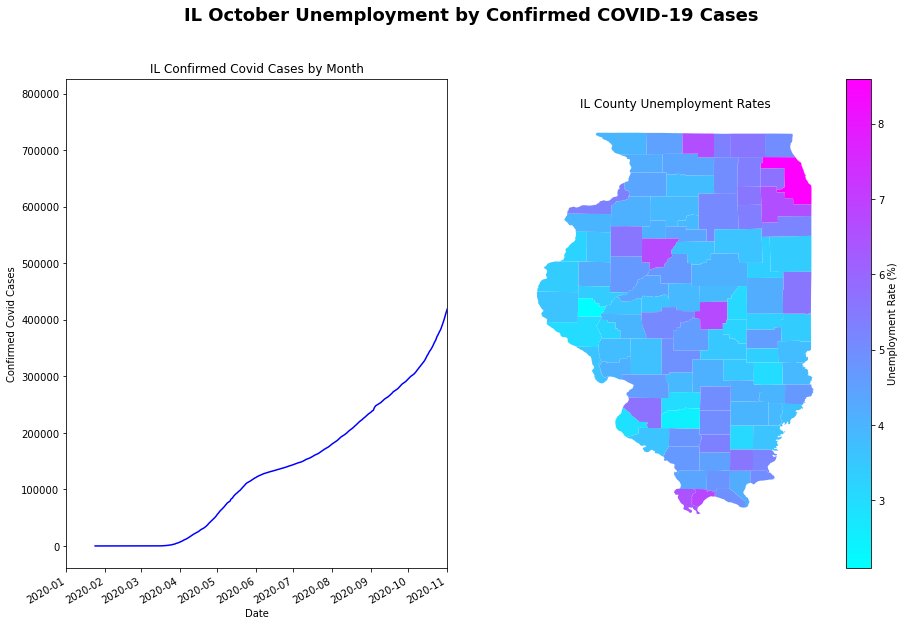

ToggleButtons(button_style='info', description='Period:', options=('01-2020', '02-2020', '03-2020', '04-2020',…

In [29]:
county_plot({'new':'10-2020'})

### Conclusion

This dashboard can be used by anyone curious to quickly and visually see how the rise in Illinois COVID-19 cases impact the unemployment rates across the state and counties of IL.  The power of visually consuming this information is more useful than simple tables or even statistical analysis when presenting to the general public. Further analysis can be added to allow more statistical depth based on the needs of the consumer; however, we start here with simple interactions and can iterate into more complex topics as needed.